Optimize a model with 1 rows, 8 columns and 8 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 4e+00]
  Bounds range     [1e+01, 1e+01]
  RHS range        [3e+01, 3e+01]
Presolve removed 0 rows and 1 columns
Presolve time: 0.01s
Presolved: 1 rows, 7 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.9324700e+01   7.765000e+00   0.000000e+00      0s
       1    7.9887700e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.988770000e+01

----------------------------------------------------------------


Total energy transferred: 26.53 kW

Minimal Charging Cost: 79.8877 ct

Total used charging time: 2.41182 h

Energy transferred during each hour:

0: 0 kW - 4.280000 ct/kW

1: 0 kW - 3.620000 ct/kW

2: 0 kW - 3.270000 ct/kW

3: 0 kW - 3.270000 ct/kW

4: 4.53 kW - 3.090000 ct/kW

5: 11 kW - 3.000000 ct/kW

6: 11 kW - 2.990000 ct/kW

7: 0 kW - 3.150

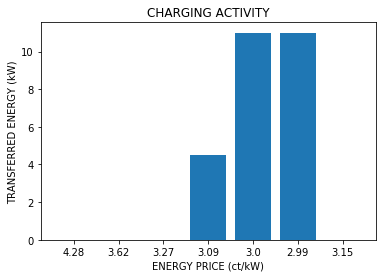

In [397]:
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt

# Car specs: BMW I3
battCap = 37.9
maxCharRateCar = 11

#Scenario values
startTime = 8
endTime = 16
SoC_per_beg = 0.1
SoC_per_end = 0.8
maxCharRateStation = 11

charRate = max(maxCharRateCar,maxCharRateStation)

prices = [2.70, 2.57, 2.40, 2.46, 2.22, 2.60,
          3.52, 4.79, 4.28, 3.62, 3.27, 3.27,
          3.09, 3.00, 2.99, 3.15, 3.22, 3.60,
          4.36, 5.44, 5.01, 4.09, 3.43, 2.90]

### Built Model
m = Model()

### Energy needed
SoC_beg = batt_cap * SoC_per_beg
SoC_end = batt_cap * SoC_per_end
sumTransferedEnergy = SoC_end - SoC_beg

### Charging time & prices
chargingDuration = endTime - startTime
chargingInterval = np.arange(chargingDuration)
realChargingDuration = sumTransferedEnergy/charRate
chargingPrices = prices[startTime:endTime]


### Variables
chargingRate = list()
for t in chargingInterval:
    chargingRate.append(m.addVar(vtype = 'C', lb=0.0, ub=charRate))
    
### Constraints
m.addConstr((quicksum(chargingRate) == sumTransferedEnergy))

m.update()

### Objective Function
m.setObjective(quicksum(chargingPrices[t]*chargingRate[t] for t in chargingInterval), GRB.MINIMIZE)

def printSolution():
    if m.status == GRB.Status.OPTIMAL:
        print('\n----------------------------------------------------------------\n')
        print('\nTotal energy transferred: %g kW' % sumTransferedEnergy)
        print('\nMinimal Charging Cost: %g ct' % m.objVal)
        print('\nTotal used charging time: %g h' % realChargingDuration)
        print('\nEnergy transferred during each hour:')
        chargex = m.getAttr('x', chargingRate)
        for t in np.arange(8):
            print('\n%s: %g kW - %f ct/kW' % (t, chargex[t], chargingPrices[t]))
    else:
        print('No solution')
        
m.optimize()
printSolution()

chargingActivity = m.getAttr('x', chargingRate)

#time_slots = ['0-1','1-2','2-3','3-4','4-5','5-6','6-7','7-8']
timeSlots = [str(chargingPrices[x]) for x in range(chargingDuration)]
plt.bar(timeSlots,chargingActivity)
plt.ylabel('TRANSFERRED ENERGY (kW)')
plt.xlabel('ENERGY PRICE (ct/kW)')
plt.title('CHARGING ACTIVITY')

plt.show()